<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">Show/Hide Code</a> 

In [1]:
%run "../../shared/utilz_image_proc.ipynb"

## 1. Kernels and Filtering

## ---- Kernelz + Blur filters----


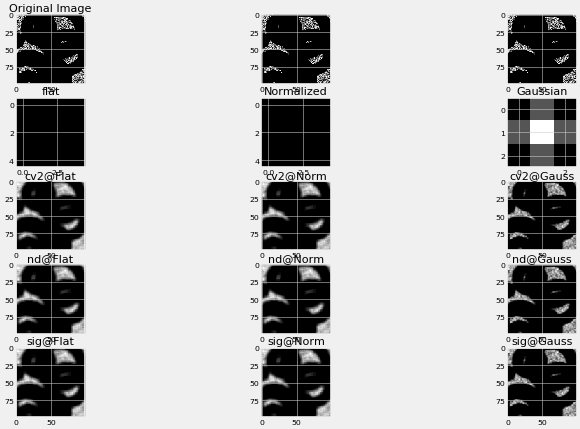

In [2]:
print("## ---- Kernelz + Blur filters----")
## all do pretty much the same thing but this is how to call them 
from scipy.signal import convolve2d
from scipy.ndimage.filters import convolve

ksize = 5
kern = np.ones( (ksize, ksize) ) 
normalized_kern = np.ones( (ksize, ksize) ) / ksize**2
gaus_kern = np.array([
    [1/16, 1/8, 1/16],
    [1/8, 1/4, 1/8],
    [1/16, 1/8, 1/16],
])

# test image
img = np.random.rand( 100, 100) 
dcolor = (0,0,0)
dthick = 15
sfact = 100
rfact = 50
for i in range(10):
    bubble_center = tuple(np.int(x*sfact) for x in np.random.rand( 1,2 )[0] )
#     print( bubble_center)
    bubble_radius = np.random.randint( rfact )
    #skimage.draw.circle( bubble_center[1], bubble_center[0], bubble_radius, shape=img.shape)
    img = cv2.circle( img, bubble_center, bubble_radius, color=dcolor, thickness=dthick)

grid_plot_images([ img, img, img, 
                  kern, normalized_kern, gaus_kern,
                  ## cv2 convolve
                  cv2.filter2D(img, -1, kern, borderType=cv2.BORDER_CONSTANT), ##borderType is padding type
                  cv2.filter2D(img, -1, normalized_kern, borderType=cv2.BORDER_CONSTANT), 
                  cv2.filter2D(img, -1, gaus_kern, borderType=cv2.BORDER_CONSTANT), 
                                    
                  ## ndimage convolve
                  convolve(img, kern, mode='constant', cval=0.0),
                  convolve(img, normalized_kern, mode='constant', cval=0.0),
                  convolve(img, gaus_kern, mode='constant', cval=0.0),
                  
                  ## scipy.signal convolve
                  convolve2d(img, kern, mode='same'),
                  convolve2d(img, normalized_kern, mode='same'),
                  convolve2d(img, gaus_kern, mode='same'),
                  
                 ], 
                 ["Original Image", None, None,
                  "flat","Normalized", "Gaussian", 
                  "cv2@Flat", "cv2@Norm", "cv2@Gauss",
                   "nd@Flat", "nd@Norm", "nd@Gauss",
                   "sig@Flat", "sig@Norm", "sig@Gauss"
                 ], 
                 nc=3, logit=False)

## 2. Fourier Transform
- Move from time domain to frequency domain. Each wave can be repd by a frequency and phase 
    - decompose a signal/wave into its core components or individual (sine) waves 
    - integral
        - but data is collected in discrete time so summation for discrete fourier transform 
        - complex numbers are involved in the coefficient
        - READ: related equations
- 
        

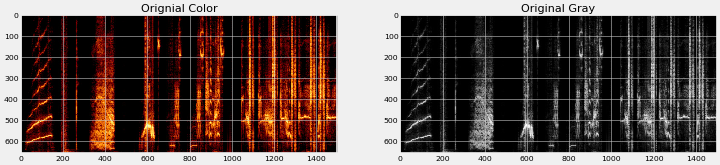

In [3]:
# ip = "https://s3.amazonaws.com/izotopedownloads/docs/rx6/img/07g-regular-stft.png"
# "https://musiclab.chromeexperiments.com/img/experiments/thumbnail_spectrogram.jpg"
# ip = "https://cdn-learn.adafruit.com/guides/cropped_images/000/000/380/medium640/spectrogram2.png?1534969157"
ip = "https://timsainb.github.io/images/birdsong2.png"
img, gimg = fetch_image( ip )
grid_plot_images( [img, gimg], ["Orignial Color", "Original Gray"], logit=False)

shape sine wave image = (256, 256)


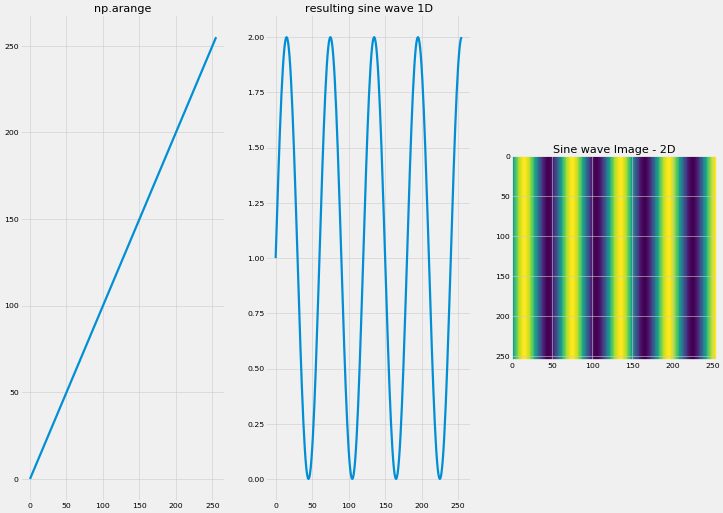

In [4]:
## Generate a 2D sine wave image 
fq = 60
x = np.arange(256)                  ## 1-d sine wave 
y = np.sin( 2* np.pi * x / fq )      ## control frequency 
y += max(y)                         ## ofset to go out of negative range of sine
sine_wave_img = np.array( [ [ y[j]*127 for j in range(256)] for i in range(256)], dtype=np.uint8)
print(f"shape sine wave image = {sine_wave_img.shape }" )

nr, nc = 1, 3
plt.subplot(nr, nc, 1)
plt.plot(x)
plt.title("np.arange")

plt.subplot(nr, nc, 2)
plt.plot(y)
plt.title("resulting sine wave 1D")

plt.subplot(nr, nc, 3)
plt.imshow(sine_wave_img);
plt.title("Sine wave Image - 2D"); 

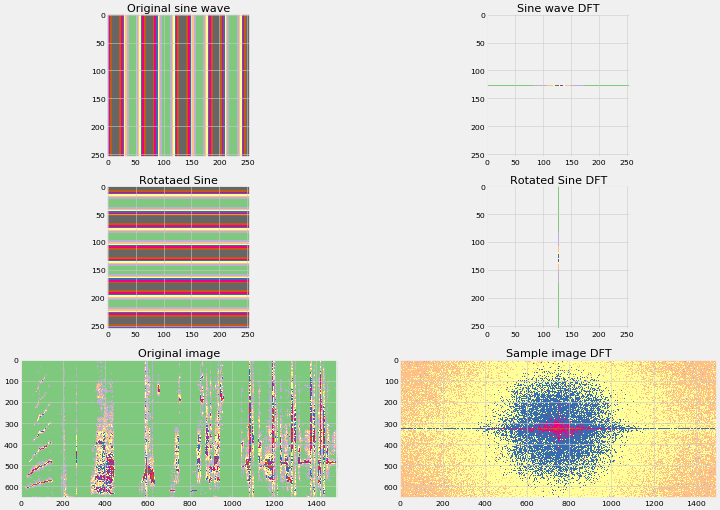

In [5]:
## Fourier Transform using CV2
#   - It works only with float32
#   - dft is for discrete fourier transform 
#   - Output has two channels b/c complex number so real part and imaginary part 

## rotated so can see how the peaks behave in opposites on DFT 
rt_sine = np.rot90( sine_wave_img )

## a. generate dft 
sine_dft = cv2.dft( np.float32(sine_wave_img), flags=cv2.DFT_COMPLEX_OUTPUT )
sine90_dft = cv2.dft( np.float32(rt_sine), flags=cv2.DFT_COMPLEX_OUTPUT )
img_dft = cv2.dft( np.float32(gimg), flags=cv2.DFT_COMPLEX_OUTPUT )

## b. by default data is centered around the origin and the origin is at top left corner. So move the origin to the center of the grid
# shift the zero frequency to center
sine_dft = np.fft.fftshift( sine_dft)
sine90_dft = np.fft.fftshift( sine90_dft)
img_dft = np.fft.fftshift( img_dft)

## c. compute the magnitude spectrum 
kil_zero = 0
sine_dftms = 20 * np.log( (cv2.magnitude(sine_dft[:,:,0], sine_dft[:,:,1]) )+kil_zero )# +1 to avoid div by zero error
sine90_dftms = 20 * np.log( (cv2.magnitude(sine90_dft[:,:,0], sine90_dft[:,:,1]) )+kil_zero )
img_dftms = 20 * np.log( (cv2.magnitude(img_dft[:,:,0], img_dft[:,:,1]) )+kil_zero )

 

grid_plot_images( [ sine_wave_img, sine_dftms, 
                   rt_sine, sine90_dftms,
                   gimg, img_dftms 
                  ], 
                 [ "Original sine wave", "Sine wave DFT", 
                   "Rotataed Sine", "Rotated Sine DFT", 
                   "Original image", "Sample image DFT"
                 ], 
                 cmapd='Accent', logit=False)

**Notes**
- Higher frequency has closer peaks in a 2d image but farther apart on the DFT graph 
- The middle represents the low frequency (after dft shift) and the corners rep the high frequency else would be vice versa
    - **Band Pass Filters:** High frequency components are the edges. So E.G. for edge detection, a high pass filter would mask out all the low frequency regions (e.g. the centers). The reverse could be a smoothing filter. 
    
- The DFT image reflects the information in the image; the constituent waves 
    - Can reconstruct image from DFT

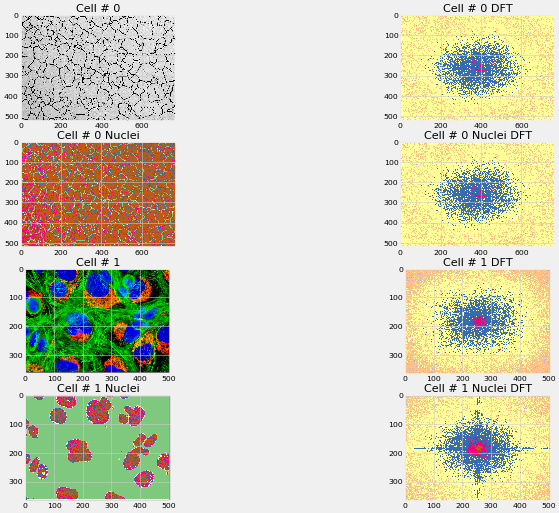

In [6]:
ipz = [
    "https://4.bp.blogspot.com/_6sy6DITvP_s/TKbdzLMBH5I/AAAAAAAABmw/1M8z5xwIcno/s1600/505h.JPG",
    "https://micro.magnet.fsu.edu/primer/techniques/fluorescence/gallery/cells/u2/images/u2large.jpg",
]

dict_cell_imagez = {}

for i, ip in enumerate(ipz):
    c, g = fetch_image( ip )
    b = nuclei_channel_only( c )
    gdft, gdftms = run_discrete_fourier_transform(g)
    bdft, bdftms = run_discrete_fourier_transform(b)
    dict_cell_imagez[f"Cell # {i}"] = (c, g, gdft, gdftms, b, bdft, bdftms )
    

plot_imgz = []
plot_tz = []

for k, v in dict_cell_imagez.items():
    plot_imgz.append( v[0] )
    plot_imgz.append( v[3] )    
    plot_imgz.append( v[4] )    
    plot_imgz.append( v[6] )
    plot_tz.append( k )
    plot_tz.append( f"{k} DFT" )
    plot_tz.append( f"{k} Nuclei" )
    plot_tz.append( f"{k} Nuclei DFT" )
    
grid_plot_images( plot_imgz, plot_tz, cmapd="Accent", logit=False)


## 3.Discrete Fourier Transform (DFT)
- **Band Pass Filtering: **

**Applications**
Generally: 
- Image filtering for edge detection or (if inverse operation) for sort of smoothing in images and video 
- Noise reduction/suppression in sound signals 

In [7]:
dft_imagez = [sine_dft, img_dft, *[ v[2] for v in dict_cell_imagez.values()], *[ v[5] for v in dict_cell_imagez.values()]]
dft_titlez = ["Sine wave DFT", "Some Image DFT", *[f"{v} DFT" for v in dict_cell_imagez.keys()], *[f"{v} Nuclei DFT" for v in dict_cell_imagez.keys()]   ]

# grid_plot_images( dft_imagez, dft_titlez, plotit=False)

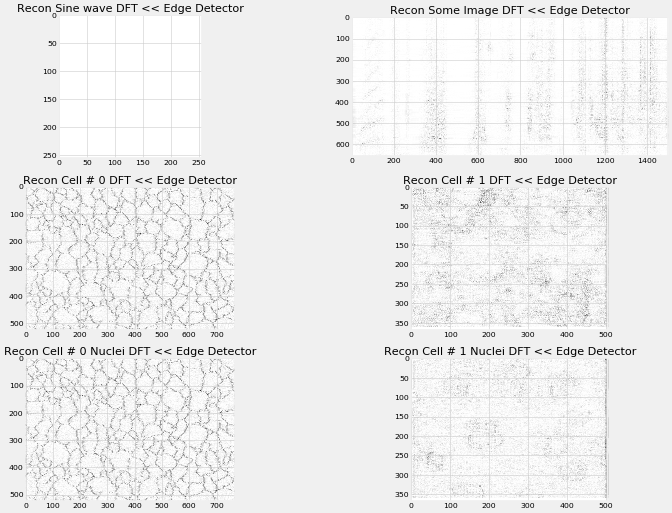

In [8]:
filtered_imagez = []

### Create a mask using dft shifted image
for dft in dft_imagez:
    # a. generate mask 
    r, c, _ = dft.shape 
    cr, cc = int(r/2), int(c/2)
    
    radius = 10
    center = [cr, cc]
    
    x, y = np.ogrid[:r, :c]
    
    mask = np.ones( (r, c, 2), np.uint8 )
    
    mask_area = ( x - center[0]**2) +(y - center[1])**2 <= radius*radius ## define a circel @ x^2 + y^2 = r^2
    
    mask[ mask_area ] = 0
    
    # b. apply mask 
    fshift = dft * mask 
    
    # c. now reconstruct image : 
#     fshift_ms = 2000 * np.log( cv2.magnitude(fshift[:,:,0], fshift[:,:,1]))
    fshift = np.fft.ifftshift( fshift ) #unshift the move of origin to center 
    
    fimg = cv2.idft( fshift ) #do inverse DFT 
    fimg = cv2.magnitude( fimg[:,:,0], fimg[:,:,1]) # calc magnitude back
    
    # d. set
    filtered_imagez.append( fimg )
    
    
    
    
grid_plot_images( filtered_imagez, [f"Recon {t} << Edge Detector" for t in dft_titlez], cmapd="binary", logit=False)



## 2.4. Discrete Cosine Transform (DCT)
- DFT converts from real space to a frequency domain. DCT does the same with the different being in terms of the use of complex functions vs real valued 
- DCT decomposes image information using real valued cosine functions 
- Like DFT, DCT is linear

**Application**
- *Data compression* e.g. in JPEG b/c most of the DCT image information is concentrated in a small number of coefficients and so can reconstruct using a relatively small number of DCT coefficients


**Extra**
- Can use an average across an image stack during denoising 


In [9]:
from scipy.fftpack import dct, idct


------- Sine wave -------
image.shape = (256, 256)
datatype = float32
min = 0.0 , max = 254.0


------- Spectogram -------
image.shape = (656, 1500)
datatype = float32
min = 0.0 , max = 250.0


------- Grain -------
image.shape = (524, 768)
datatype = float32
min = 0.0 , max = 255.0


------- Nuclei -------
image.shape = (368, 508)
datatype = float32
min = 0.0 , max = 255.0



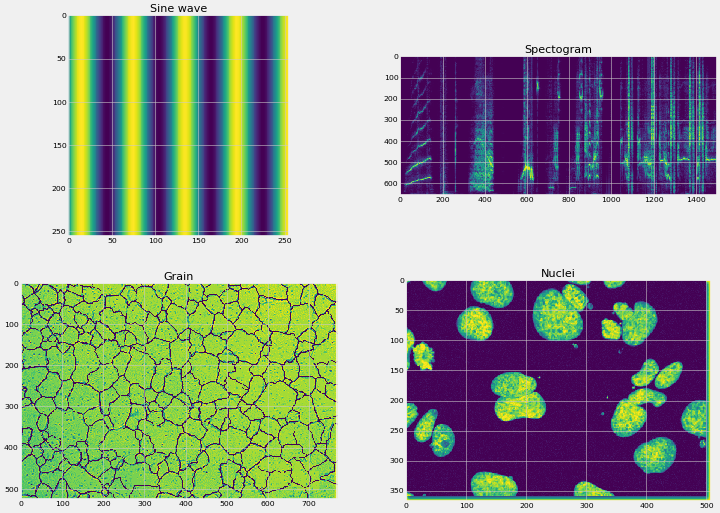

In [10]:
##using dict_cell_imagez
# read in images as grayscale and float32
imagez = [ np.float32(sine_wave_img), np.float32(gimg), 
              *[ np.float32(v[4]) for v in dict_cell_imagez.values() ] 
         ]
titlez = ["Sine wave", "Spectogram", "Grain", "Nuclei"]
grid_plot_images(imagez, titlez, plotit=True, cmapd=None)

Max H = 656, Max W = 1500


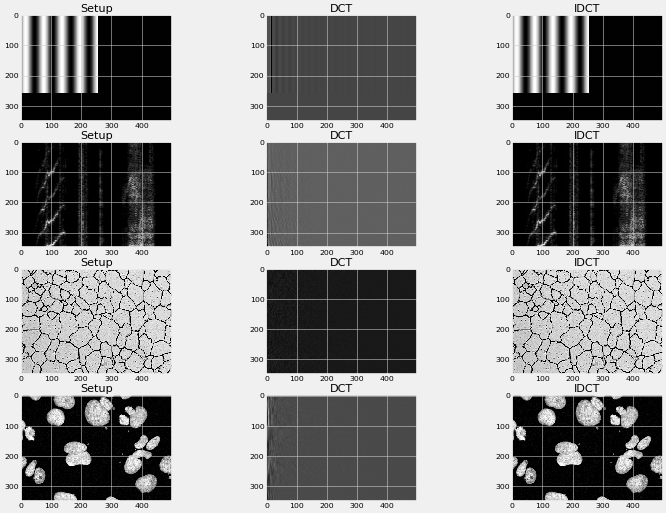

In [11]:
## Apply weighted average to images and corresponding DCT images <<< Assuming same conditions@images
max_height, max_width = np.max( [x.shape[0] for x in imagez] ), np.max( [x.shape[1] for x in imagez] )
print( f"Max H = {max_height}, Max W = {max_width}" )

crop_height, crop_width = 350, 500

## initiate to zero 
avg_img = np.zeros( (crop_height, crop_width), np.float32 ) 
dct_avg_img = np.zeros( (crop_height, crop_width), np.float32 ) 

tmp = []
tmp_tz = []
for i in range( len(imagez)):
    # long way just for kicks 
    g, im = np.ones( (max_height, max_width), np.float32 ), imagez[i]
    g[ :im.shape[0], :im.shape[1] ] = im  #lay small image on large canvas
    g = g[:crop_height, :crop_width] # crop image 
    tmp.append( g  )
    tmp_tz.append("Setup")
    # a. individual dct
    tmp.append( dct( g ) )
    tmp_tz.append("DCT")    
    # b. reverse/reconstruct individual 
    tmp.append( idct( dct(g) ) )
    tmp_tz.append("IDCT")
    
    # c. ELSE averaged over stack of images    
    avg_img = cv2.addWeighted( avg_img, i/(i+1.), g, 1/(i+1.), 0 )
    dct_avg_img = cv2.addWeighted( dct_avg_img, i/(i+1.), dct(g), 1/(i+1.), 0 )


grid_plot_images( tmp, tmp_tz, nc=3, logit=False)


------- Average on Original -------
image.shape = (350, 500)
datatype = float32
min = 0.0 , max = 199.5


------- Average on DCT -------
image.shape = (350, 500)
datatype = float32
min = -0.015289306640625 , max = 199500.0



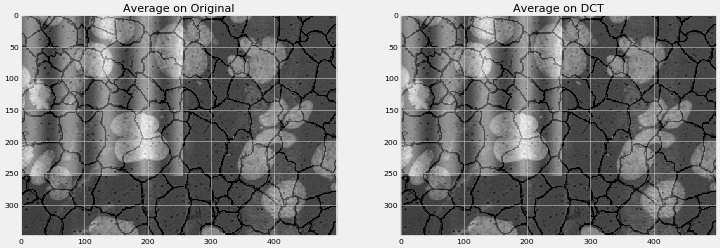

In [12]:
## Reconstruct image from average <<< this may be weired b/c not same reference but should superimpose/overlay all as clean

grid_plot_images( [ avg_img, idct(dct_avg_img)], ["Average on Original", "Average on DCT"] )

**Notes**
- The two images above should be identical. DCT doesn't loose information???
- The resulting matrices are similar and differ by some scaling factor 



------- Mask @ Average on Original -------
image.shape = (350, 500)
datatype = float32
min = 0.0 , max = 180.75


------- Mask @ Average on DCT -------
image.shape = (350, 500)
datatype = float32
min = -15621.236328125 , max = 194242.109375



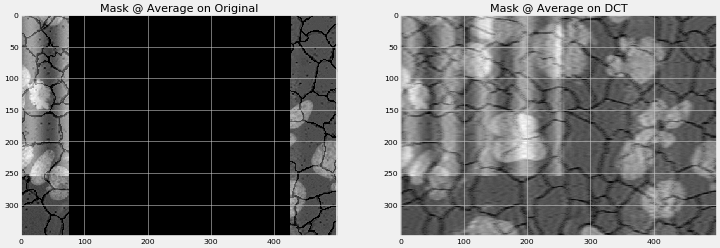

In [16]:
## What Happens if we mask DCT like we did with DFT

dctz = []
for i, dc in enumerate([avg_img, dct_avg_img]):
    # a. generate mask 
    r, c = dc.shape 
    cr, cc = int(r/2), int(c/2)

    radius = 10
    center = [cr, cc]

    x, y = np.ogrid[:r, :c]

    mask = np.ones( (r, c), np.uint8 ) #normalize / (r*c)

    mask_area = ( x - center[0]**2) +(y - center[1])**2 <= radius*radius ## define a circel @ x^2 + y^2 = r^2

    mask[ mask_area ] = 0

    # b. apply mask 
    fimg = dc * mask 

    # c. now reconstruct image : 
    if i == 1:
        fimg = idct( fimg )
        
    # d. set
    dctz.append( fimg )
    
grid_plot_images( dctz, ["Mask @ Average on Original", "Mask @ Average on DCT"] )

**Notes:** 
- Applying mask on the averaged original pixels simply clears out the mask area.
- Applying mask on the averaged DCT image results in smoothing (denoising) 

In [ ]:
gaus_kern